In [1]:
import requests
import zipfile
import os
import pandas as pd

url = "https://archive.ics.uci.edu/static/public/352/online+retail.zip"
zip_file_path = "online_retail.zip"
xlsx_file_name = "Online Retail.xlsx"

# Step 1: Download the ZIP file
response = requests.get(url)
with open(zip_file_path, 'wb') as file:
    file.write(response.content)

# Step 2: Extract the XLSX file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

# Construct the full path to the XLSX file
xlsx_file_path = os.path.join(os.getcwd(), xlsx_file_name)

# Step 3: Read the XLSX file
df = pd.read_excel(xlsx_file_path)

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


# Clean
- drop nulls by customerID (drop for now or create new IDs)
- drop duplicates

In [15]:
data = df.copy()

# Step 4: Clean the data
# show duplicates
print('duplicates rows', data.duplicated().sum())
#show the number of missing values for each column
data.isnull().sum()

duplicates rows 5268


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [16]:
# drop all Nulls by customerID
data = data.dropna(subset=['CustomerID'])


# Cohort Analysis

In [39]:
import datetime as dt 

# get the cohort month
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

data['InvoiceMonth'] = data['InvoiceDate'].apply(get_month)

# group by customerID and select the InvoiceMonth value
data['CohortMonth'] = data.groupby('CustomerID')['InvoiceMonth'].transform('min')


In [40]:
# create a date element function to get a series for subtraction
def get_date_elements(df, column):
    day = df[column].dt.day
    month = df[column].dt.month
    year = df[column].dt.year
    return day, month, year 

In [41]:
# get date elements for our cohort and invoice columns
_,Invoice_month,Invoice_year =  get_date_elements(data,'InvoiceMonth')
_,Cohort_month,Cohort_year =  get_date_elements(data,'CohortMonth')

In [42]:
#create a cohort index 
year_diff = Invoice_year -Cohort_year
month_diff = Invoice_month - Cohort_month
data['CohortIndex'] = year_diff*12+month_diff+1

In [43]:
#count the customer ID by grouping by Cohort Month  and Cohort Index 
cohort_data = data.groupby(['CohortMonth','CohortIndex'])['CustomerID'].apply(pd.Series.nunique).reset_index()

In [44]:
# create a pivot table 
cohort_table = cohort_data.pivot(index='CohortMonth', columns=['CohortIndex'],values='CustomerID')
# change index
cohort_table.index = cohort_table.index.strftime('%B %Y')

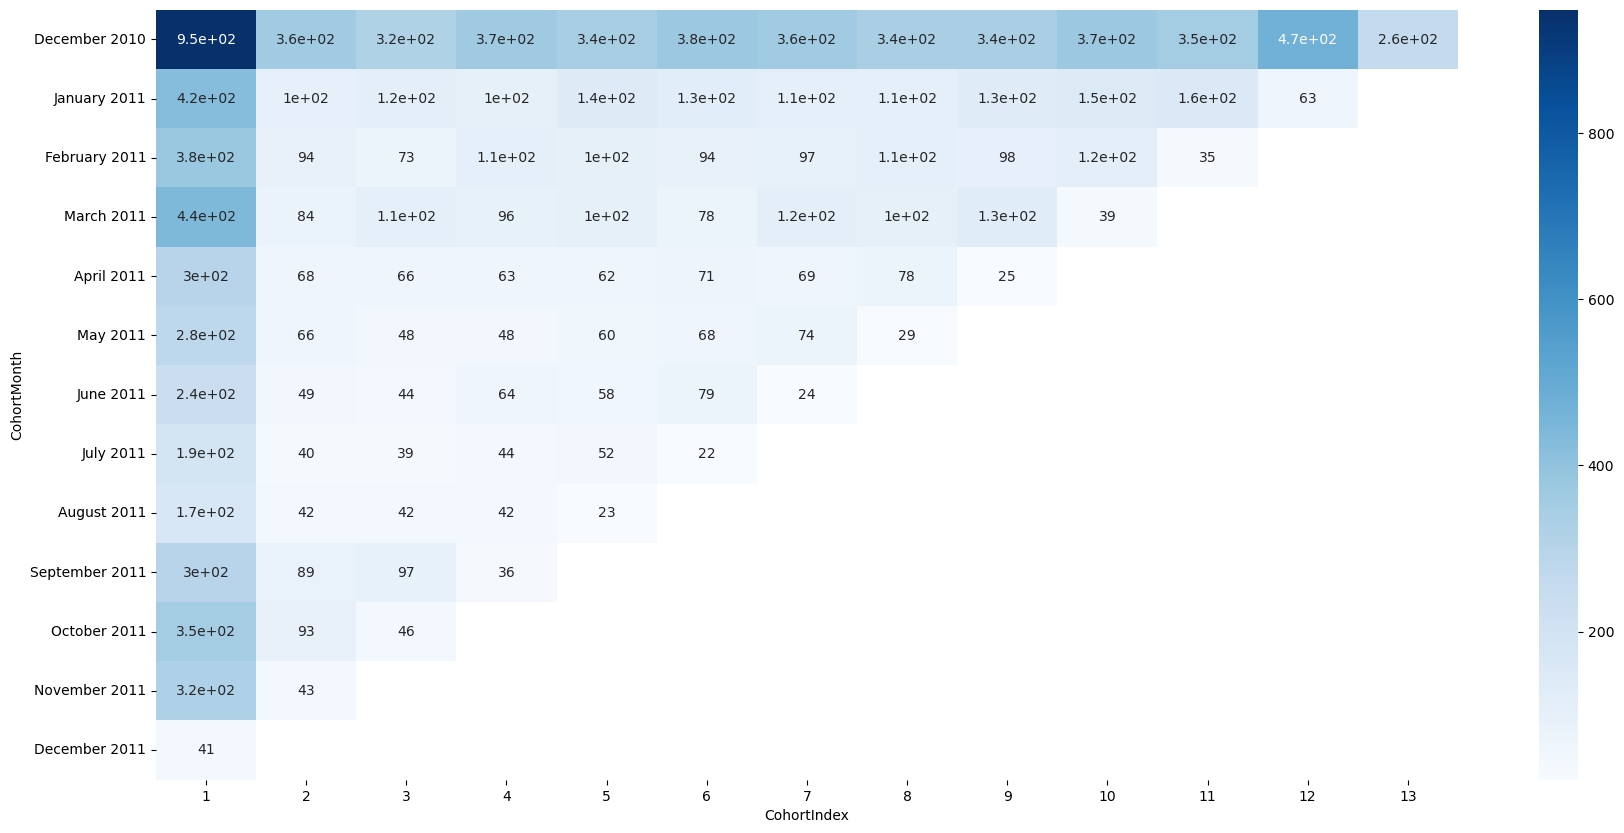

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(21,10))
sns.heatmap(cohort_table,annot=True,cmap='Blues')
plt.show()

<Axes: xlabel='CohortIndex', ylabel='CohortMonth'>

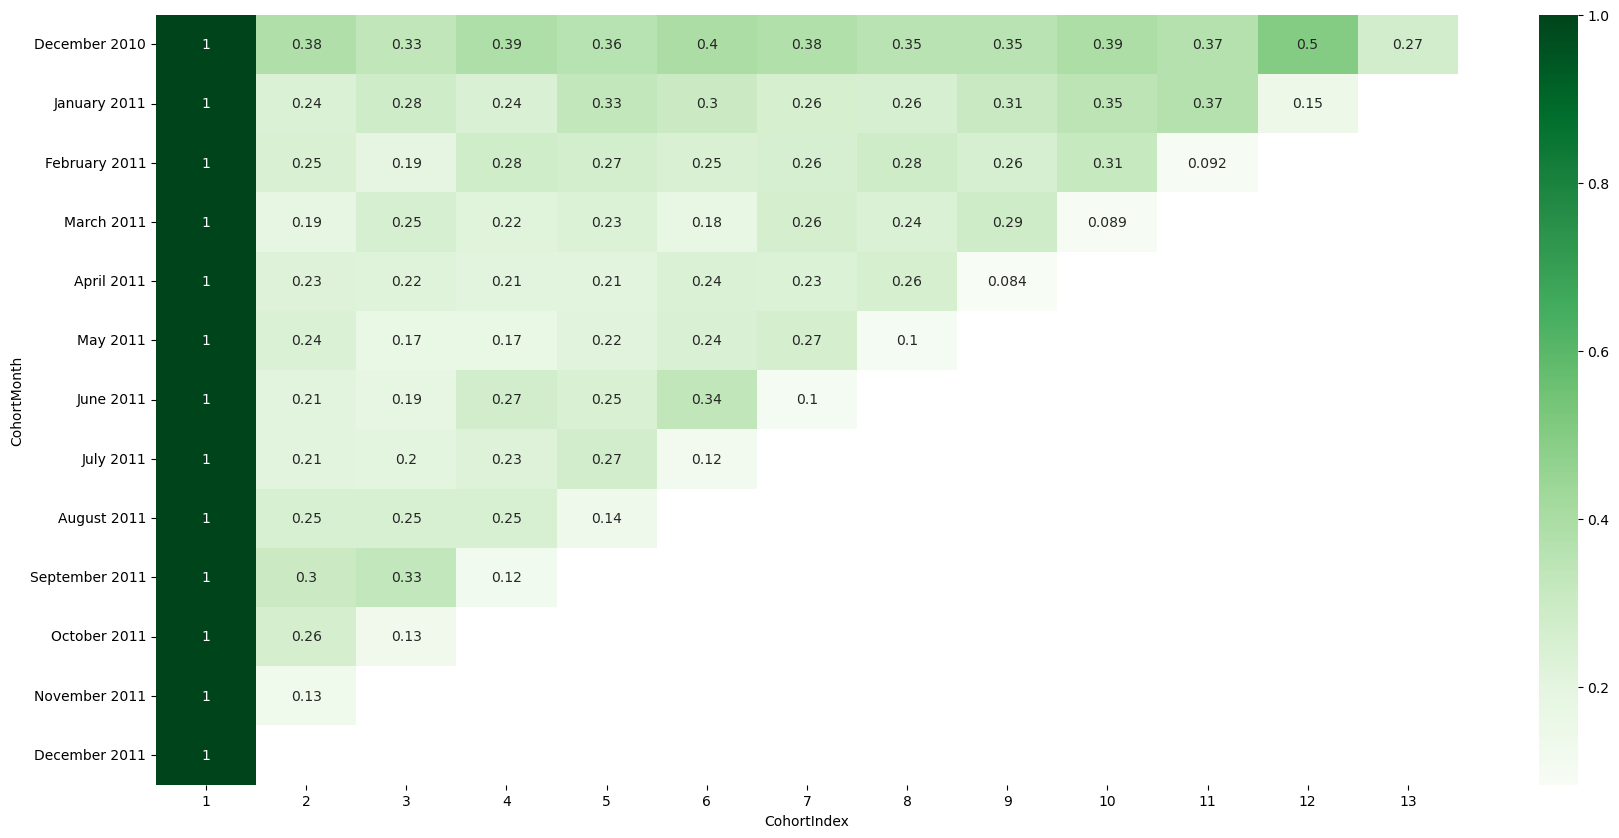

In [46]:
#cohort table for percentage
new_cohort_table = cohort_table.divide(cohort_table.iloc[:,0],axis=0)
#create a percentages visual
plt.figure(figsize=(21,10))
sns.heatmap(new_cohort_table,annot=True,cmap='Greens')

# Recency Frequency Monetary

In [47]:
# Recency Frequency Monetary
# Step 1: Create a RFM table
# Create a TotalSum column that contains the total amount spent per transaction
data['TotalSum'] = data['Quantity'] * data['UnitPrice']

# Create a snapshot date
snapshot_date = max(data.InvoiceDate) + dt.timedelta(days=1)

# Group by CustomerID
data_process = data.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

# Rename the columns
data_process.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)

# Step 2: Build the RFM Segments
# Build the RFM segmentation
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5)

# Assign these labels to three equal percentile groups
r_groups = pd.qcut(data_process['Recency'], q=4, labels=r_labels)

# Assign these labels to three equal percentile groups
f_groups = pd.qcut(data_process['Frequency'], q=4, labels=f_labels)

# Create new columns R and F
data_process = data_process.assign(R = r_groups.values, F = f_groups.values)

# Create labels for MonetaryValue
m_labels = range(1, 5)

# Assign these labels to three equal percentile groups
m_groups = pd.qcut(data_process['MonetaryValue'], q=4, labels=m_labels)

# Create new column M
data_process = data_process.assign(M = m_groups.values)

# Concat RFM quartile values to create RFM Segments
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])

data_process['RFM_Segment_Concat'] = data_process.apply(join_rfm, axis=1)

# Calculate RFM_Score
data_process['RFM_Score'] = data_process[['R','F','M']].sum(axis=1)

# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'High'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9)):
        return 'Medium'
    else:
        return 'Low'
    
# Create a new variable RFM_Level
data_process['RFM_Level'] = data_process.apply(rfm_level, axis=1)

# Print the header with top 5 rows to the console
print(data_process.head())


            Recency  Frequency  MonetaryValue  R  F  M RFM_Segment_Concat  \
CustomerID                                                                  
12346.0         326          2           0.00  1  1  1          1.01.01.0   
12347.0           2        182        4310.00  4  4  4          4.04.04.0   
12348.0          75         31        1797.24  2  2  4          2.02.04.0   
12349.0          19         73        1757.55  3  3  4          3.03.04.0   
12350.0         310         17         334.40  1  1  2          1.01.02.0   

            RFM_Score RFM_Level  
CustomerID                       
12346.0             3       Low  
12347.0            12      High  
12348.0             8    Medium  
12349.0            10      High  
12350.0             4       Low  
